In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import torch.nn.functional as F
from sklearn.svm import SVC
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (brier_score_loss, 
                             confusion_matrix, ConfusionMatrixDisplay)
import statsmodels.api as sm


In [44]:
# 1) Load data
data_path = 'bci_log_withemg.csv'
df = pd.read_csv(data_path)

# Drop timestamp
df = df.drop(columns=['timestamp'])

LABEL_MAP = {
    'close': 0,
    'pinch': 1,
    'rest': 2,
    'close-ARM': 0,
    'pinch-LEG': 1,
    0: 'close',
    1: 'pinch',
    2: 'rest'
}
# Encode mode labels
df['mode_label'] = [LABEL_MAP[k] for k in df['mode']]

# Features and labels
# features = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0','mode', 'mode_label', 'filtered_mode']).values
featurenames = ['ch_1_mu', 'ch_2_mu', 'ch_3_mu', 'ch_4_mu', 
                'ch_5_mu', 'ch_6_mu', 'ch_7_mu', #'ch_8_mu', 
                'ch_1_beta', 'ch_2_beta', 'ch_3_beta', 'ch_4_beta', 
                'ch_5_beta', 'ch_6_beta', 'ch_7_beta', 'ch_8_emg']
                #'accel_0', 'accel_1', 'accel_2']
# featurenames = ['ch_1','ch_2','ch_3','ch_4',
#                 'ch_5','ch_6','ch_7','ch_8',
#                 'accel_0','accel_1','accel_2']
# featurenames = ['ch_8_emg']
features = df[featurenames].values
labels = df['mode_label'].values




In [45]:
print(features[:,0].shape)
print(len(features))

(160479,)
160479


In [22]:
time_features = np.array([hjorth(features[:,i]) for i in range(features.shape[1])])
print(time_features)

[[6.25434489e-04 4.16393726e+02]
 [6.24231407e-04 4.16338362e+02]
 [6.24380605e-04 4.15675053e+02]
 [6.21734028e-04 4.15799716e+02]
 [6.25928418e-04 4.14076564e+02]
 [6.10127772e-04 4.13688863e+02]
 [6.21920769e-04 4.15807505e+02]
 [7.09541187e-06 2.14581986e+05]
 [6.09529261e-06 2.49747086e+05]
 [5.67895320e-06 2.68596344e+05]
 [6.89008201e-06 2.24309394e+05]
 [1.11285288e-05 1.32835243e+05]
 [4.93988725e-06 2.54700732e+05]
 [5.56155257e-06 2.73224236e+05]
 [3.33934452e-03 4.82260661e+02]]


In [ ]:
def hjorth(X, D=None):
    """ Compute Hjorth mobility and complexity of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, a first order differential sequence of X (if D is provided,
           recommended to speed up)

    In case 1, D is computed using Numpy's Difference function.

    Notes
    -----
    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.

    Parameters
    ----------

    X
        list

        a time series

    D
        list

        first order differential sequence of a time series

    Returns
    -------

    As indicated in return line

    Hjorth mobility and complexity

    """

    if D is None:
        D = np.diff(X)
        D = D.tolist()

    D.insert(0, X[0])  # pad the first difference
    D = np.array(D)

    n = len(X)

    M2 = float(sum(D ** 2)) / n
    TP = sum(np.array(X) ** 2)
    M4 = 0
    for i in range(1, len(D)):
        M4 += (D[i] - D[i - 1]) ** 2
    M4 = M4 / n

    return np.sqrt(M2 / TP), np.sqrt(
        float(M4) * TP / M2 / M2
    )  # Hjorth Mobility and Complexity


In [70]:
# Scale features
scaler = StandardScaler()

# features = scaler.fit_transform(features)

# 2) Create sliding windows
WINDOW_SIZE = 200  # e.g., 1 second at 250Hz
STEP_SIZE = 25    # 50% overlap

split_ratio = 0.9
split_index = int(len(features) * split_ratio)

# Split BEFORE windowing:
X_train_seq = features[:split_index]
y_train_seq = labels[:split_index]

X_test_seq = features[split_index:]
y_test_seq = labels[split_index:]

# Then window each separately with same function:
def create_windows(features, labels, window_size, step_size):
    X = []
    y = []
    for start in range(0, len(features) - window_size + 1, step_size):
        end = start + window_size
        X_window = features[start:end]
        y_window = labels[start:end]
        # label = np.bincount(y_window).argmax()
        label = labels[start + window_size // 2]
        X.append(X_window)
        y.append(label)
    return np.array(X), np.array(y)


X_train, y_train = create_windows(X_train_seq, y_train_seq, WINDOW_SIZE, STEP_SIZE)
X_test, y_test = create_windows(X_test_seq, y_test_seq, WINDOW_SIZE, STEP_SIZE)
print(X_train.shape)

# Now we create a bunch of datapoints using the hjorth num
new_column_features = []
for name in featurenames:
    new_column_features.append(f"{name}_com")
    new_column_features.append(f"{name}_mob")
new_df = pd.DataFrame(columns = new_column_features + ["mode_label"])

total_new_X_train = []

def turn_into_classification(dataset):
    total = []
    for sample in dataset:
        sample_row = []
        for feature_idx in range(sample.shape[1]):
            feature_sample = sample[:,feature_idx]
            hjorth_array = hjorth(feature_sample)
            sample_row.append(hjorth_array[0])
            sample_row.append(hjorth_array[1])
            rho, sigma2 = sm.regression.linear_model.burg(feature_sample, order=8)
            sample_row.extend(rho)
            sample_row.append(sigma2)
        total.append(sample_row)
    return np.array(total)

total_new_X_train = turn_into_classification(X_train)
total_new_X_test = turn_into_classification(X_test)

# total_new_X_train = np.array(total_new_X_train)
# total_new_X_test = []
# for sample in X_test:
#     hjorth_array = np.array([hjorth(sample[:,i]) for i in range(sample.shape[1])])
#     sample_row = []
#     for i in range(hjorth_array.shape[0]):
#         sample_row.append(hjorth_array[i][0])
#         sample_row.append(hjorth_array[i][1])
#     total_new_X_test.append(sample_row)

    
# total_new_X_test = np.array(total_new_X_test)

print(total_new_X_train.shape)
print(y_train.shape)

(5770, 200, 15)
(5770, 165)
(5770,)


In [71]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(total_new_X_train, y_train)
print(clf.best_estimator_)

SVC(C=np.float64(1371.0510729583423), class_weight='balanced',
    gamma=np.float64(0.00011215832912422456))


Classification report for classifier RandomizedSearchCV(estimator=SVC(class_weight='balanced'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13baeb710>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13ee01040>}):
              precision    recall  f1-score   support

           0       0.54      0.91      0.68       164
           1       0.88      0.78      0.83       244
           2       0.89      0.56      0.69       226

    accuracy                           0.74       634
   macro avg       0.77      0.75      0.73       634
weighted avg       0.80      0.74      0.74       634




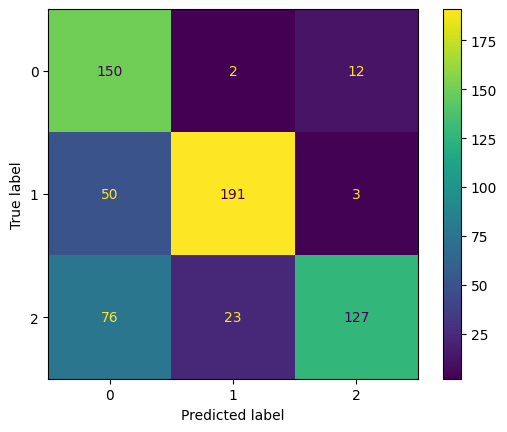

In [72]:
y_pred_test = clf.predict(total_new_X_test)
print(
    f"Classification report for classifier {clf}:\n"
    f"{classification_report(y_test, y_pred_test)}\n"
)
cm = confusion_matrix(y_test, y_pred_test, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [ ]:
input_size = X_train.shape[2]  # 11 features
hidden_size = 128
num_layers = 2
num_classes = 3
print(f"{num_classes=}")

print(f"{input_size=}, {hidden_size=}, {num_layers=}, {num_classes=}")



class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        return loss.mean() if self.reduction == 'mean' else loss.sum()

# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean', weight=class_weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# 7) Training loop
def train(model, loader):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()*X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    print(classification_report(all_labels, all_preds))
    return correct / total, total_loss/len(loader.dataset), f1_score(all_labels, all_preds, average='macro')

EPOCHS = 100
best_f1 = 0
save_path = 'lstm_best_dual.pth'
backup_save_path = 'lstm_dual_backup.pth'
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader)
    val_acc, val_loss, f1 = evaluate(model, test_loader)
    print(f"Epoch {epoch}: Train loss {train_loss:.4f} | Test accuracy {val_acc:.4f} | Val loss {val_loss:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, save_path)
        print(f"Model saved at epoch {epoch} with f1 {best_f1:.4f}")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, backup_save_path)